In [514]:
import numpy as np
import matplotlib.pyplot as plt
from filterpy.common import Q_discrete_white_noise
from filterpy.kalman import UnscentedKalmanFilter as UKF
from filterpy.kalman import MerweScaledSigmaPoints
import math
from math import sin as sin
from math import cos as cos
import time

In [515]:

# Main-Funktion
if __name__ == "__main__":

    std_0 = 0.01  # Std. für Beacon 0
    std_1 = 0.01  # Std. für Beacon 1
    std_2 = 0.01 # Std. für Beacon 2
    std_h = 0.01  # Std. für Kompass
    
    beacon0_pos = np.array([-15, 0])
    beacon1_pos = np.array([15, 0])
    beacon2_pos = np.array([-1, -5])

    samples = 100

    dT = 0.1

    np.random.seed(int(time.time()))
    

In [516]:
def f_x(state, dt):
    """
    Zustandsübergangsfunktion.
    Da die Geschwindigkeit konstant ist und der Zustand nur die Position beinhaltet,
    hat diese Funktion einfach die Geschwindigkeit zur Position hinzugefügt.
    TODO: Später Orientierungswinkel rein (und Winkel in der Messfunktion beachten)
    """  
    x, y, vx, vy, ax, ay = state

    # Update position with current velocity and acceleration
    new_x = x + vx * dt + (ax * dt ** 2) / 2.0
    new_y = y + vy * dt + (ay * dt ** 2) / 2.0

    # Update velocity with current acceleration
    new_vx = vx + ax * dt
    new_vy = vy + ay * dt

    # Speed stays constant (no acceleration yet)
    new_ax = ax
    new_ay = ay

    return np.array([new_x, new_y, new_vx, new_vy, new_ax, new_ay])

In [517]:
def h_x(state):

    def normalize_angle(x):
        """
        Funktion von R. Labbe
        """
        x = x % 360    # force in range [0, 360)
        if x > 180:          # move to [-180, 180)
            x -= 360
        return x
    
    def normalize_vector(v):
        """
        Länge von Vektor ist hiernach 1.0
        """
        x = v[0]
        y = v[1]
        mag = np.sqrt(x ** 2 + y ** 2)
        return np.array([x / mag, y / mag])

    def times(mat, vec):
        return np.array([
            vec[0] * mat[0] + vec[1] * mat[1],
            vec[0] * mat[2] + vec[1] * mat[3]            
            ])

    """
    Messfunktion.
    Bildet den Zustandsraum (Position und Geschwindigkeit des Schiffs)
    auf den Messraum ab (Winkel von den Funktürmen), wobei definiert als:
    - Norden als 0°, 
    - Osten als 270°,
    - Süden als 180°,
    - Westen als 90°.
    """
    x, y, vx, vy, _, _ = state

    # Calculate vectors in worldspace
    hdg = normalize_vector([vx, vy])
    b0 = normalize_vector([beacon0_pos[0] - x, beacon0_pos[1] - y])
    b1 = normalize_vector([beacon1_pos[0] - x, beacon1_pos[1] - y])
    b2 = normalize_vector([beacon2_pos[0] - x, beacon2_pos[1] - y])

    # ships rotation-mat and its inverser
    ship_mat_ws = np.array([
        hdg[1], hdg[0],
        -hdg[0], hdg[1]
    ])

    ship_mat_ws_inv = np.array([
        hdg[1], -hdg[0],
        +hdg[0], hdg[1]
    ])

    # convert b0, b1 and b2 from worldspace to ships modelspace
    b0 = times(ship_mat_ws_inv, b0)
    b1 = times(ship_mat_ws_inv, b1)
    b2 = times(ship_mat_ws_inv, b2)

    return np.array([hdg[0], hdg[1], b0[0], b0[1], b1[0], b1[1], b2[0], b2[1]])

In [518]:
# Berechne die echten Status der ersten 10 Sekunden, das Schiff fährt Kurven, Geschwindigkeit nicht konstant

states = [] # pos_x, pos_y, vel_x, vel_y, acc_x, acc_y (constatn acceleration model, actually not, because direction is changing)

x = 0
y = 0
vx = 0
vy = 0
ax = 0
ay = 0

for i in range(samples):

    x = 5 * sin(i * dT)
    y = -10 + 2 * i * dT

    if(i != 0): # calculate velocity of previous state with position of current state
        states[i - 1][2] = (x - states[i - 1][0]) / dT
        states[i - 1][3] = (y - states[i - 1][1]) / dT
        vx = states[i - 1][2]
        vy = states[i - 1][3]

    states.append(np.array([x, y, vx, vy, ax, ay]))


In [519]:
# Berechne die verrauschten Messdaten

def noise_vector(x, y, std):
    """
    ToDo: normalisieren! und Maß für STD überlegen
    """
    return np.array([x + np.random.randn() * std, y + np.random.randn() * std])

zs = []

for i in range(samples):
    h = h_x(states[i])
    hdg = noise_vector(h[0], h[1], std_h)
    b0 = noise_vector(h[2], h[3], std_0)
    b1 = noise_vector(h[4], h[5], std_1)
    b2 = noise_vector(h[6], h[7], std_2)

    zs.append(np.array([hdg[0], hdg[1], b0[0], b0[1], b1[0], b1[1], b2[0], b2[1]]))

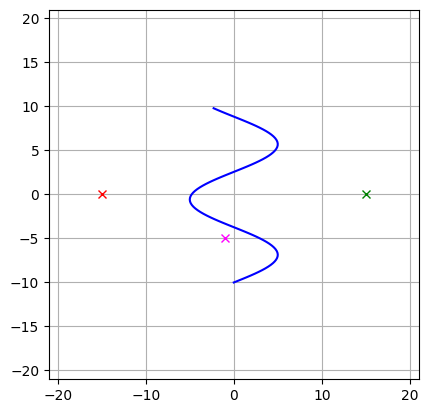

In [520]:
# visualisiere echten Zustand

x_val = [s[0] for s in states]
y_val = [s[1] for s in states]

fig, ax = plt.subplots()
plt.xlim(-21, 21)
plt.ylim(-21, 21)
ax.set_aspect('equal')

plt.plot(x_val, y_val, color = 'blue')

plt.plot(beacon0_pos[0], beacon0_pos[1], marker = 'x', color='red')
plt.plot(beacon1_pos[0], beacon1_pos[1], marker = 'x', color='green')
plt.plot(beacon2_pos[0], beacon2_pos[1], marker = 'x', color='magenta')

plt.grid(True)

plt.show()

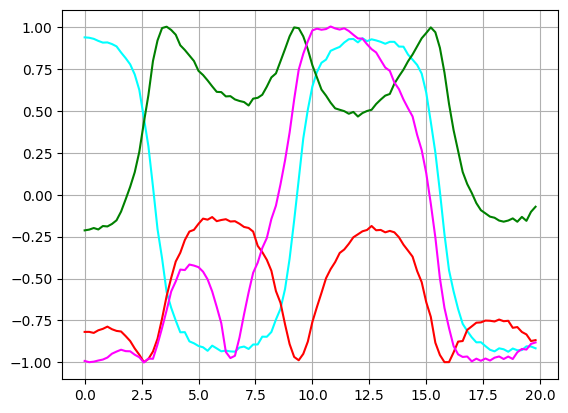

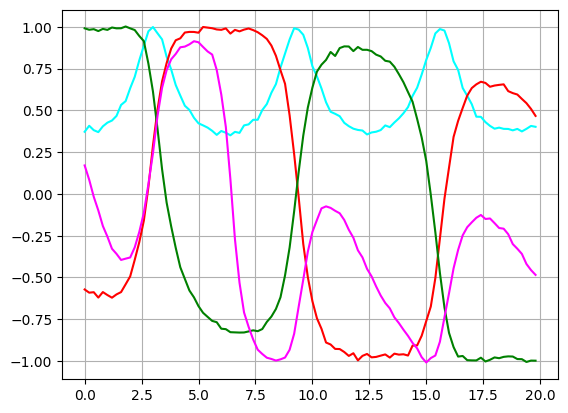

In [521]:
# visualisiere messdaten X (diese sind verrauscht)

heading_val = [z[0] for z in zs]
beacon0_val = [z[2] for z in zs]
beacon1_val = [z[4] for z in zs]
beacon2_val = [z[6] for z in zs]
t = [(2 * i * dT) for i in range(samples)]

plt.plot(t, heading_val, color = 'cyan')
plt.plot(t, beacon0_val, color = 'red')
plt.plot(t, beacon1_val, color = 'green')
plt.plot(t, beacon2_val, color = 'magenta')
plt.grid(True)
plt.show()


# visualisiere messdaten Y (diese sind verrauscht)

heading_val = [z[1] for z in zs]
beacon0_val = [z[3] for z in zs]
beacon1_val = [z[5] for z in zs]
beacon2_val = [z[7] for z in zs]
t = [(2 * i * dT) for i in range(samples)]

plt.plot(t, heading_val, color = 'cyan')
plt.plot(t, beacon0_val, color = 'red')
plt.plot(t, beacon1_val, color = 'green')
plt.plot(t, beacon2_val, color = 'magenta')
plt.grid(True)
plt.show()

In [522]:
# UKF

sigmas = MerweScaledSigmaPoints(n = 6, alpha = 0.1, beta = 2.0, kappa = 1.0)

ukf = UKF(dim_x = 6, dim_z = 8, fx = f_x, hx = h_x, dt = dT, points = sigmas)

ukf.x = states[0].copy()
ukf.R = np.diag([std_h ** 2, std_h ** 2, std_0 ** 2, std_0 ** 2, std_1 ** 2, std_1 ** 2, std_2 ** 2, std_2 ** 2])
ukf.Q = Q_discrete_white_noise(dim = 2, dt = dT, var = 2, block_size = 3, order_by_dim = False)

In [523]:
# bereche position mit UKF

uxs = []
uPs = []

for z in zs:

    ukf.predict()
    ukf.update(z)

    uxs.append(ukf.x.copy())
    uPs.append(ukf.P.copy())

uxs = np.array(uxs)

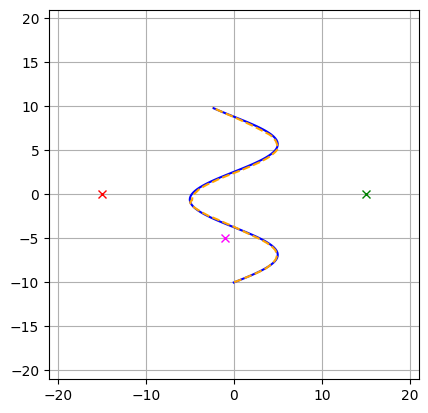

In [524]:
# visualisiere gefilterten Zustand

x_val = [s[0] for s in states]
y_val = [s[1] for s in states]

ux_val = [s[0] for s in uxs]
uy_val = [s[1] for s in uxs]

fig, ax = plt.subplots()
plt.xlim(-21, 21)
plt.ylim(-21, 21)
ax.set_aspect('equal')

plt.plot(x_val, y_val, color = 'blue')
plt.plot(ux_val, uy_val, color = 'orange', linestyle='--')

plt.plot(beacon0_pos[0], beacon0_pos[1], marker = 'x', color='red')
plt.plot(beacon1_pos[0], beacon1_pos[1], marker = 'x', color='green')
plt.plot(beacon2_pos[0], beacon2_pos[1], marker = 'x', color='magenta')

plt.grid(True)

plt.show()

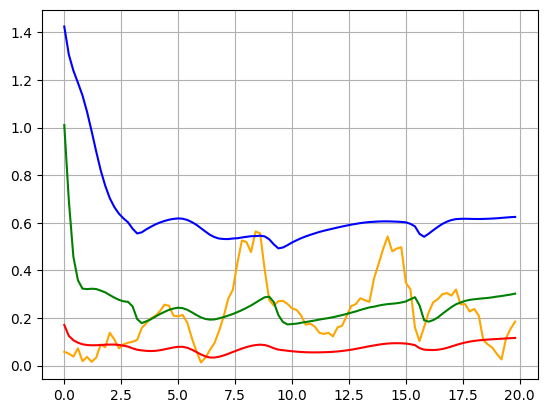

In [525]:
# visualisiere Abweichung und P

delta = []
p_pos = []
p_vel = []
p_acc = []

for i in range(samples):
    delta.append(np.sqrt((states[i][0] - uxs[i][0]) ** 2 + (states[i][1] - uxs[i][1]) ** 2))
    p_pos.append(np.sqrt(uPs[i][0][0] + uPs[i][1][1])) # sqrt( sqrt(a)**2 + sqrt(b)**2)) -> sqrt(a + b); varianz == std**2
    p_vel.append(np.sqrt(uPs[i][2][2] + uPs[i][3][3]))
    p_acc.append(np.sqrt(uPs[i][4][4] + uPs[i][5][5]))


t = [(2 * i * dT) for i in range(samples)]

plt.plot(t, delta, color = 'orange')
plt.plot(t, p_pos, color = 'red')
plt.plot(t, p_vel, color = 'green')
plt.plot(t, p_acc, color = 'blue')
plt.grid(True)
plt.show()